In [1]:
library(ggplot2)
library(ggrepel)
library(WGCNA)
library(tidyverse)
library(CorLevelPlot)
library(gridExtra)
library(gprofiler2)
library(ggpubr)
library(reshape2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Warning message:
"package 'WGCNA' was built under R version 4.2.3"
Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor


Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.2"
Warning message:
"package 'forcats' was

In [2]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/WGCNA")

In [4]:
norm_df<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/PRPS_voom_norm_control.txt")
norm_df_samples<-gsub("\\.", "-", colnames(norm_df))
colnames(norm_df)<-norm_df_samples

In [5]:
samples_info<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/samples_info.csv")
samples_info$Well_ID <- sub(".*_", "", samples_info$sample)
rownames(samples_info)<-samples_info$sample

In [8]:
gsg <- goodSamplesGenes(t(norm_df))
summary(gsg)

gsg$allOK

table(gsg$goodGenes)
table(gsg$goodSamples)

 Flagging genes and samples with too many missing values...
  ..step 1


            Length Class  Mode   
goodGenes   20548  -none- logical
goodSamples    38  -none- logical
allOK           1  -none- logical

[1] TRUE


 TRUE 
20548 


TRUE 
  38 

In [10]:
norm_df <- norm_df[gsg$goodGenes == TRUE,]


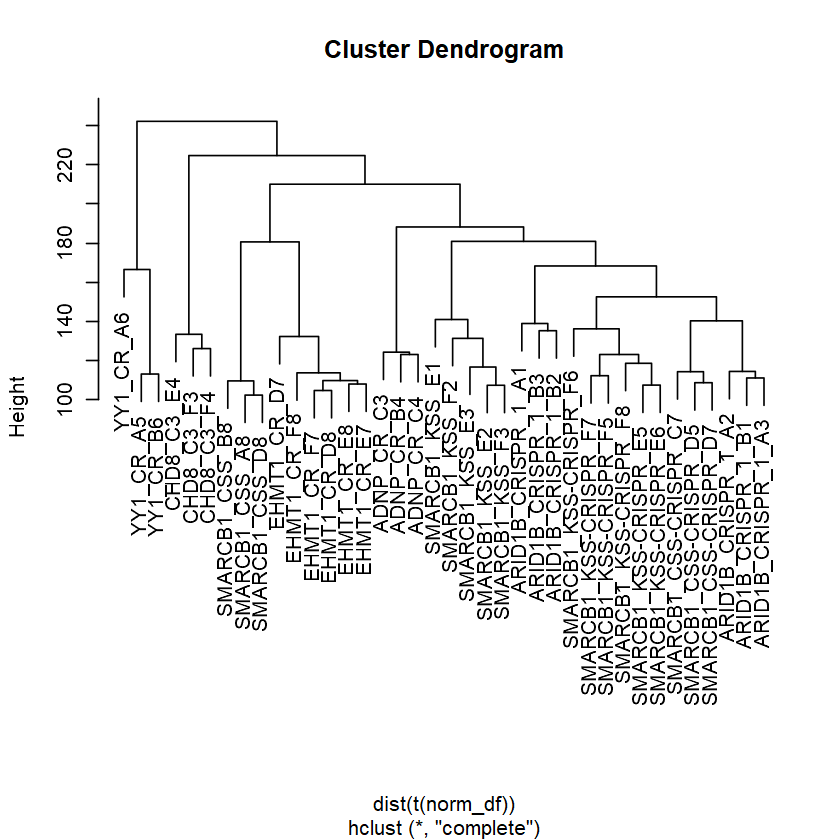

In [11]:
htree <- hclust(dist(t(norm_df)), method = "complete")
plot(htree)

In [13]:
norm.counts<-t(norm_df)

In [16]:
# 4. Network Construction  ---------------------------------------------------
# Choose a set of soft-thresholding powers
power <- c(c(1:10), seq(from = 12, to = 50, by = 2))

# Call the network topology analysis function
sft <- pickSoftThreshold(norm.counts,
                  powerVector = power,
                  networkType = "signed",
                  verbose = 5)
sft.data <- sft$fitIndices

pickSoftThreshold: will use block size 2177.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2177 of 20548


Warning message:
"executing %dopar% sequentially: no parallel backend registered"


   ..working on genes 2178 through 4354 of 20548
   ..working on genes 4355 through 6531 of 20548
   ..working on genes 6532 through 8708 of 20548
   ..working on genes 8709 through 10885 of 20548
   ..working on genes 10886 through 13062 of 20548
   ..working on genes 13063 through 15239 of 20548
   ..working on genes 15240 through 17416 of 20548
   ..working on genes 17417 through 19593 of 20548
   ..working on genes 19594 through 20548 of 20548
   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.0208  4.65          0.953 1.04e+04  1.04e+04 11200.0
2      2   0.0169  2.17          0.945 5.62e+03  5.62e+03  6550.0
3      3   0.0292 -1.44          0.949 3.22e+03  3.20e+03  4180.0
4      4   0.0363 -1.04          0.942 1.93e+03  1.91e+03  2840.0
5      5   0.1180 -1.41          0.940 1.21e+03  1.19e+03  2040.0
6      6   0.2350 -1.60          0.943 7.89e+02  7.62e+02  1520.0
7      7   0.3520 -1.67          0.945 5.30e+02  5.03e+02  1170.0
8      8   0.4730 -1

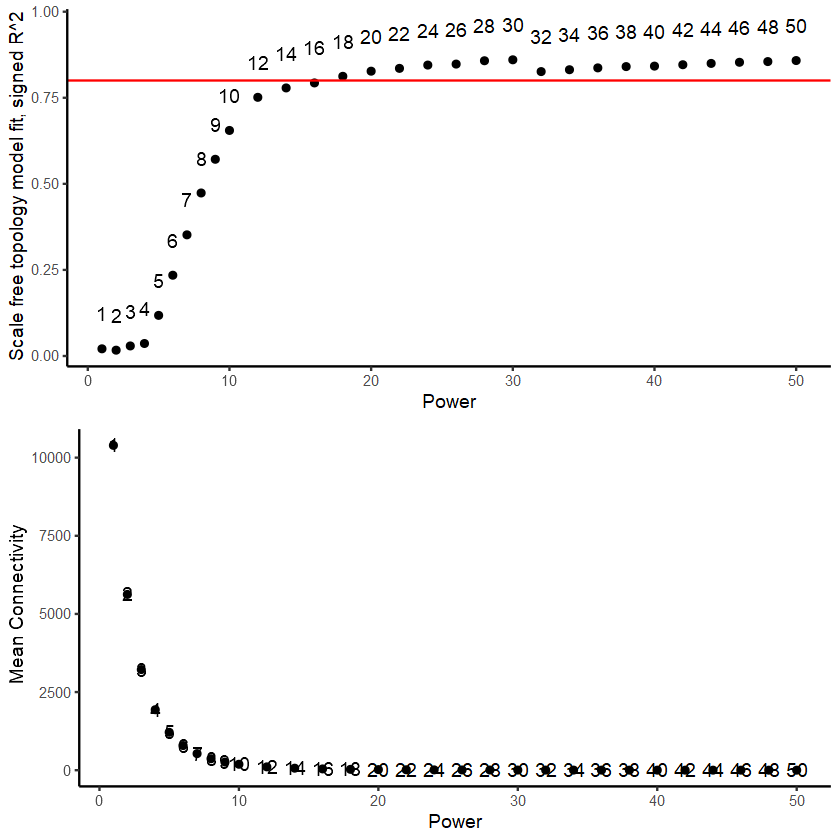

In [17]:
#visualization to pick power

a1 <- ggplot(sft.data, aes(Power, SFT.R.sq, label = Power)) +
  geom_point() +
  geom_text(nudge_y = 0.1) +
  geom_hline(yintercept = 0.8, color = 'red') +
  labs(x = 'Power', y = 'Scale free topology model fit, signed R^2') +
  theme_classic()


a2 <- ggplot(sft.data, aes(Power, mean.k., label = Power)) +
  geom_point() +
  geom_text(nudge_y = 0.1) +
  labs(x = 'Power', y = 'Mean Connectivity') +
  theme_classic()
  

grid.arrange(a1, a2, nrow = 2)

In [18]:
blockSize<-length(norm.counts[1,])+1
blockSize

[1] 20549

In [19]:
temp_cor <- cor
cor <- WGCNA::cor
sum(is.na(colnames(norm.counts)))
sum(is.na(norm.counts))
str(norm.counts)

[1] 0

[1] 0

 num [1:38, 1:20548] 0.582 0.497 0.805 -0.325 -0.24 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:38] "ADNP_CR_B4" "ADNP_CR_C3" "ADNP_CR_C4" "EHMT1_CR_E8" ...
  ..$ : chr [1:20548] "TSPAN6" "TNMD" "DPM1" "SCYL3" ...


In [20]:
# memory estimate w.r.t blocksize
soft_power <- 16 #then try 16 maybe? 

bwnet <- blockwiseModules(norm.counts,
                 maxBlockSize = blockSize,
                 TOMType = "signed",
                    networkType ="signed",
               # corType="bicor",
                 power = soft_power,
                 mergeCutHeight = 0.25,
                 numericLabels = FALSE,
                 randomSeed = 1234,
                 verbose = 3)


 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 7 genes from module 1 because their KME is too low.
     ..removing 11 genes from module 2 because their KME is too low.
     ..removing 9 genes from module 3 because their KME is too low.
     ..removing 1 genes from module 4 because their KME is too low.
     ..removing 4 genes from module 6 because their KME is too low.
     ..removing 3 genes from module 10 because their KME is too low.
     ..removing 2 genes from module 11 because their KME is too low.
     ..removing 1 genes from module 12 bec

In [22]:
cor <- temp_cor


# 5. Module Eigengenes ---------------------------------------------------------
module_eigengenes <- bwnet$MEs


# Print out a preview
head(module_eigengenes)

,MEsteelblue,MEblack,MEfloralwhite,MEdarkgreen,MEsalmon,MEyellow,MEdarkmagenta,MEdarkolivegreen,MEskyblue,MEplum1,⋯,MEturquoise,MEdarkorange,MEbrown4,MElightsteelblue1,MEgreenyellow,MEmidnightblue,MEpink,MEblue,MEdarkslateblue,MEgrey
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADNP_CR_B4,0.0655835588,0.29527245,0.20960978,-0.12603174,0.1063890,-0.021233668,-0.01909065,-0.27063792,-0.3465514,0.03630110,⋯,-0.2160946,-0.25922646,-0.27873559,-0.005299870,-0.2154491,-0.010855893,0.06047209,-0.11004431,-0.20926115,0.17536151
ADNP_CR_C3,-0.0316918426,0.23154481,0.12316562,-0.10720941,0.1233287,-0.005372047,-0.04465187,-0.22893149,-0.3961637,0.05819470,⋯,-0.1693871,-0.20671490,-0.28509978,0.006280532,-0.1836063,-0.027617120,0.07295501,-0.10046792,-0.21992070,0.16035193
ADNP_CR_C4,0.0001944695,0.29527312,0.27854521,-0.11824485,0.0841100,-0.022816993,-0.04694970,-0.27330479,-0.4165381,0.06025823,⋯,-0.1680904,-0.21231957,-0.29055134,0.017124815,-0.1780718,-0.007189054,0.08515572,-0.09037582,-0.16748896,0.17180469
EHMT1_CR_E8,0.0609044569,-0.17086524,0.03966032,-0.08076099,-0.1632209,0.026269789,-0.02684436,-0.16211073,-0.1349332,-0.12604109,⋯,0.2754274,-0.08519536,0.11656637,0.056269986,0.1859445,0.046011585,0.09587696,0.03251733,0.09215003,-0.04738090
EHMT1_CR_F7,0.0390289577,-0.22813250,-0.10842215,-0.21234905,-0.2198762,-0.010646166,-0.01904273,-0.07478383,-0.1893059,-0.08511180,⋯,0.2908603,-0.09949290,0.13362973,0.051143675,0.2651854,0.057310040,0.12652803,0.11469727,0.14536646,-0.03294251
EHMT1_CR_F8,0.0725491598,-0.07156978,0.16785830,-0.14731622,-0.2108407,-0.018794342,-0.05408359,-0.09028022,-0.1653566,-0.14454497,⋯,0.2557932,-0.14130363,0.09814952,0.026251449,0.2411572,0.053368760,0.10462008,0.08686916,0.08155328,-0.01740073


In [23]:
write.csv(module_eigengenes, "module_eigengenes_NT_signed_sp16.csv")


        bisque4           black            blue           brown          brown4 
             31             765            1287            1162              31 
           cyan       darkgreen        darkgrey     darkmagenta  darkolivegreen 
            362             168             153             102             109 
     darkorange     darkorange2         darkred   darkslateblue   darkturquoise 
            138              33             205              31             163 
    floralwhite           green     greenyellow            grey          grey60 
             34             953             395            3160             335 
          ivory       lightcyan      lightcyan1      lightgreen lightsteelblue1 
             34             345              47             323              59 
    lightyellow         magenta   mediumpurple3    midnightblue          orange 
            288             615              63             354             139 
     orangered4   paleturqu

$mar
[1] 1 5 0 1

png 
  2

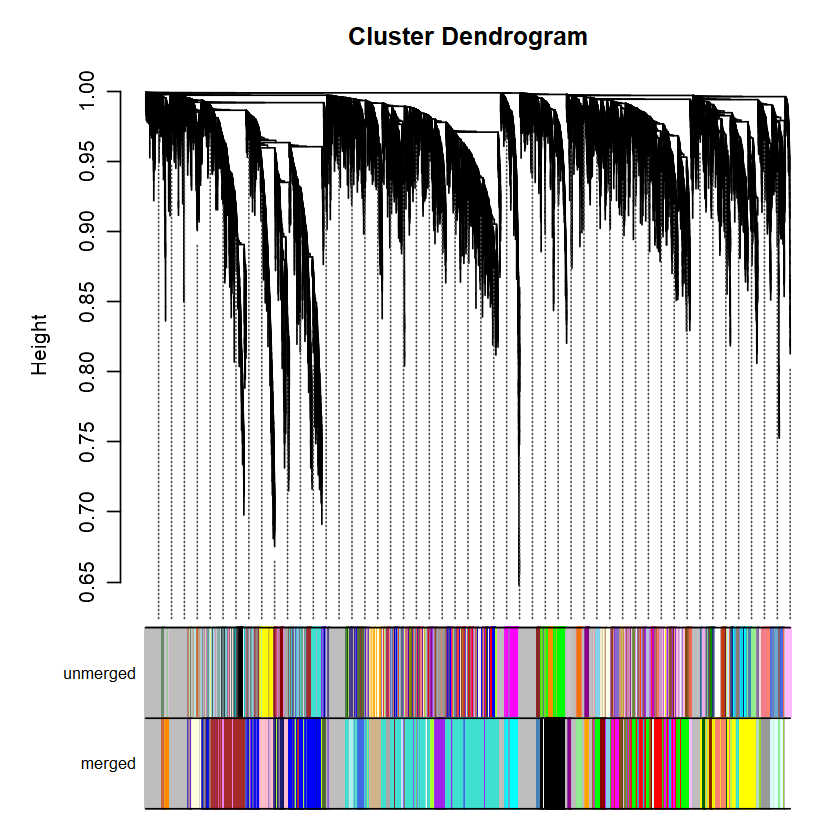

In [24]:
# get number of genes for each module
table(bwnet$colors)

# Plot the dendrogram and the module colors before and after merging underneath
p<-plotDendroAndColors(bwnet$dendrograms[[1]], cbind(bwnet$unmergedColors, bwnet$colors),
                    c("unmerged", "merged"),
                    dendroLabels = FALSE,
                    addGuide = TRUE,
                    hang= 0.03,
                    guideHang = 0.05)
p


png("dendrogram_modules_sp16.png", width=6, height=4, units="in", res=400)
plotDendroAndColors(bwnet$dendrograms[[1]], cbind(bwnet$unmergedColors, bwnet$colors),
                    c("unmerged", "merged"),
                    dendroLabels = FALSE,
                    addGuide = TRUE,
                    hang= 0.03,
                    guideHang = 0.05)

dev.off()

# grey module = all genes that doesn't fall into other modules were assigned to the grey module
write.csv(table(bwnet$colors),"number_of_genes_per_merged_modules_sp16.csv")

In [25]:
genes_modules<-as.data.frame(bwnet$colors)
genes_modules$gene<-rownames(genes_modules)
names(genes_modules)<-c("module","gene")

In [26]:
write.csv(genes_modules,"genes_modules_sp16.csv")